In [39]:
import pickle
import numpy as np
from matplotlib import pylab as plt
import torch
import torchdiffeq

In [28]:
import plotting
from helper import get_device, data_to_torch
from ode_helper import solve_and_plot
from analytical_solutions import solution_pendulum_theta, solution_pendulum_xy

In [51]:
from itertools import cycle
from collections import defaultdict

In [23]:
device=get_device()

Using the CPU


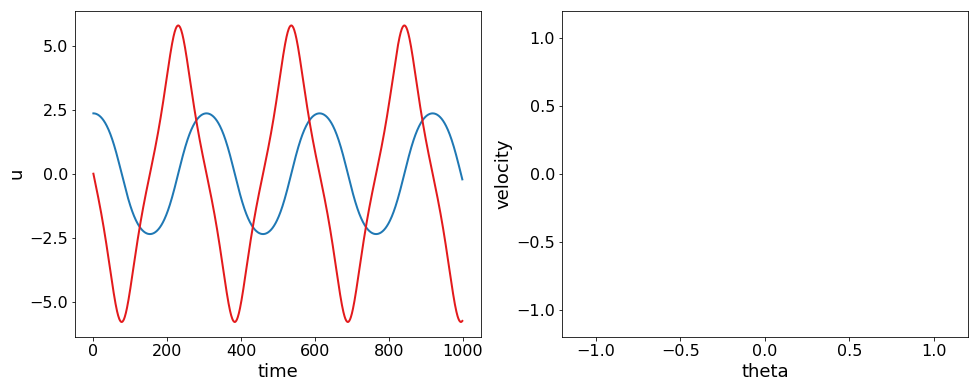

In [29]:
t_max = 10
N_time_step = 1000
dt = t_max/N_time_step
anal_ts = np.linspace(0,t_max,N_time_step)
data = solution_pendulum_theta(anal_ts, 1.5*np.pi/2)
plotting.trajectory_plots([data])
theta_ts = data_to_torch(anal_ts,device)#.reshape(-1,1)
theta_data = data_to_torch(data,device)#.reshape(-1,1,data.shape[-1])

In [40]:
def solve_and_plot(model, model_ts, data, data_ts=None, method='rk4', idcs=0):
    if data_ts is None:
        data_ts = model_ts
    with torch.no_grad():
        pred = torchdiffeq.odeint(model, data[0,:], model_ts, method=method)
    plt.plot(data_ts.cpu().numpy(), data.detach().cpu().numpy()[:,idcs], '--')
    plt.plot(model_ts.cpu().numpy(), pred.detach().cpu().numpy()[:,idcs],'x-')

In [74]:
ts_double = torch.linspace(0,t_max,N_time_step//10)
ts_half = torch.linspace(0,t_max,N_time_step*10)
def plot_3x3(model, data, data_ts, idcs=slice(0,2),
             trained_on=(True,False,False) ):
    label = lambda x : "trained on" if x else "inference"
    plt.figure(figsize=(plotting.FIG_SIZE_FULL[0],plotting.FIG_SIZE_FULL[1]*2))
    plots = [('euler',   f'Euler ({label(trained_on[0])})'),
             ('midpoint',f'Midpoint ({label(trained_on[1])})'),
             ('rk4',     f'RK4 ({label(trained_on[1])})')]
    ts_sets = [(ts_half,'$1/10\times\Delta t$'), (data_ts,'Trained $\Delta t$'), (ts_double, ' $10\times\Delta t')]
    for j,(tset,tlabel) in enumerate(ts_sets):
        for i,(method,title) in enumerate(plots):
            plt.subplot(3,3,1+3*j+i)
            plt.title(title)
            solve_and_plot(model,tset, data,data_ts,method,idcs=idcs)
            if(i==0): plt.ylabel(tlabel+'\n x(t),y(t)')
            if(j==3-1): plt.xlabel('t')
            plt.ylim(-1.3,1.3)
    plt.tight_layout()

In [60]:
hs = [0.02,0.05,0.1,0.2,0.5,0.6,0.9,1.0,1.1,1.5,2.0,5.0,7.5,10.0,12,15,20]

In [56]:
hs = [0.02,0.05,0.1,0.2,0.5,0.6,0.9,1.0,1.1,1.5,2.0,5.0,7.5,10.0,12,15,20]
def plot_error_rates(runs):
    plt.figure(figsize=plotting.FIG_SIZE_FULL)
    colorwheel = cycle('rkgby')
    markerwheel = cycle('osd')
    colordict = defaultdict(lambda : next(colorwheel))
    markerdict = defaultdict(lambda:next(markerwheel))
    for name,errset in runs.items():
        for k,err in errset.items():
            plt.loglog(hs,err,label=name+'_'+k,color=colordict[name],marker=markerdict[k])
    plt.axvline(1.0)
    plt.ylabel('error from true solution')
    plt.xlabel('time step scaling')
    plt.ylim(bottom=10**-6)
    plt.legend()
    #plt.show()

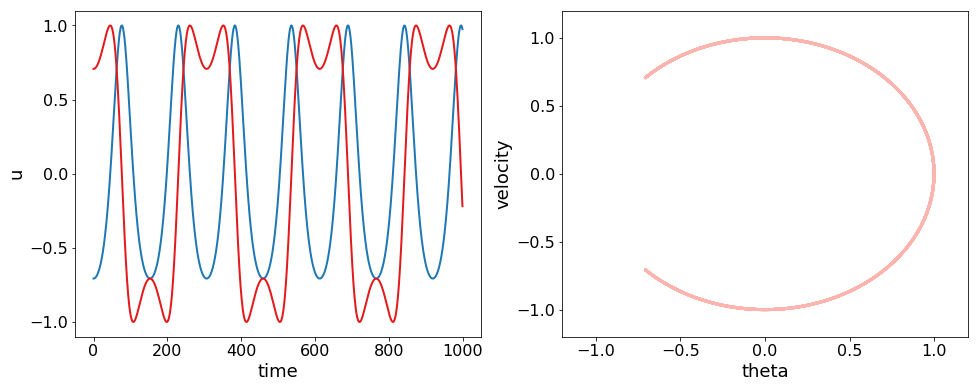

In [53]:
t_max = 10
N_time_step = 1000
dt = t_max/N_time_step
xy_anal_ts = np.linspace(0,t_max,N_time_step)
xy_data = solution_pendulum_xy(xy_anal_ts, 1.5*np.pi/2)
plotting.trajectory_plots([xy_data])
xy_ts = data_to_torch(xy_anal_ts,device)#.reshape(-1,1)
xy_data = data_to_torch(xy_data,device)#.reshape(-1,1,data.shape[-1])

In [58]:
xy_models = torch.load("results/pendulum_xy_models.pkl")
with open("results/pendulum_xy_conv.pkl","rb") as f:
    xy_runs = pickle.load(f)

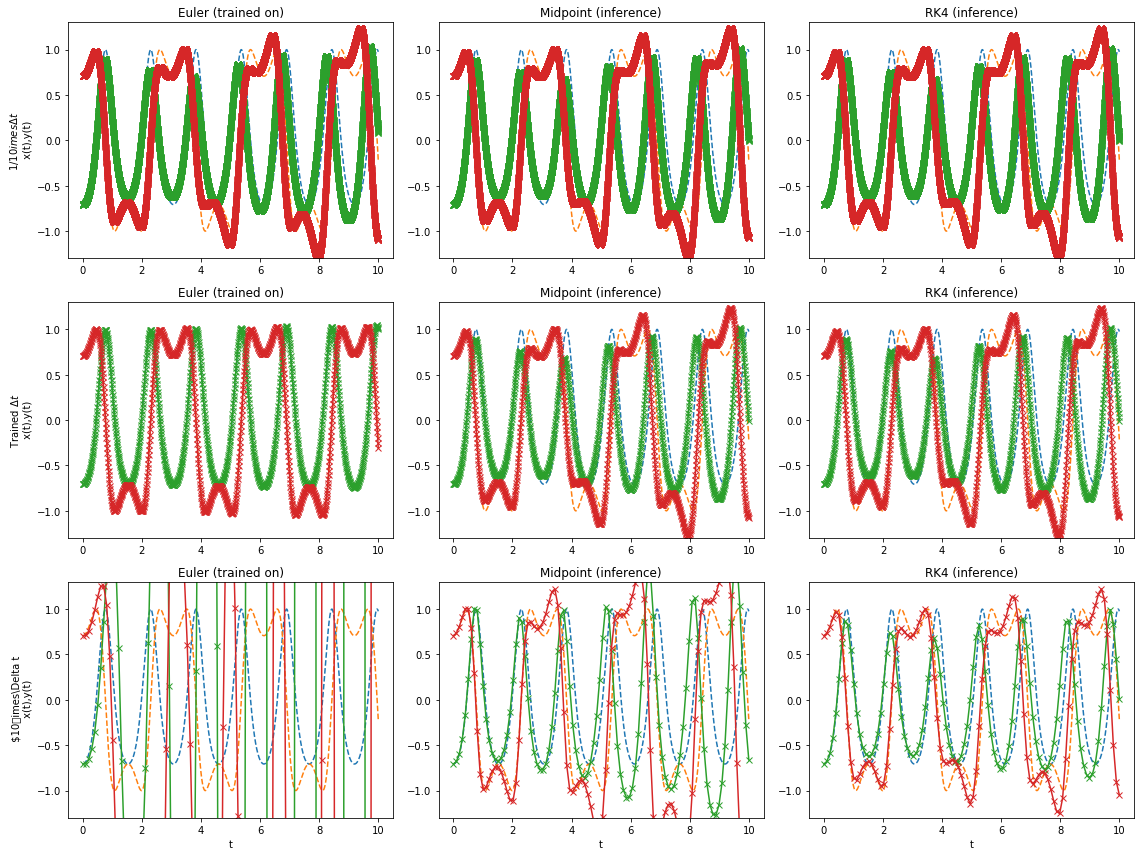

In [75]:
plot_3x3(xy_models['euler'],xy_data,xy_ts)
plt.savefig('plots/pend_xy_infer_euler.png')

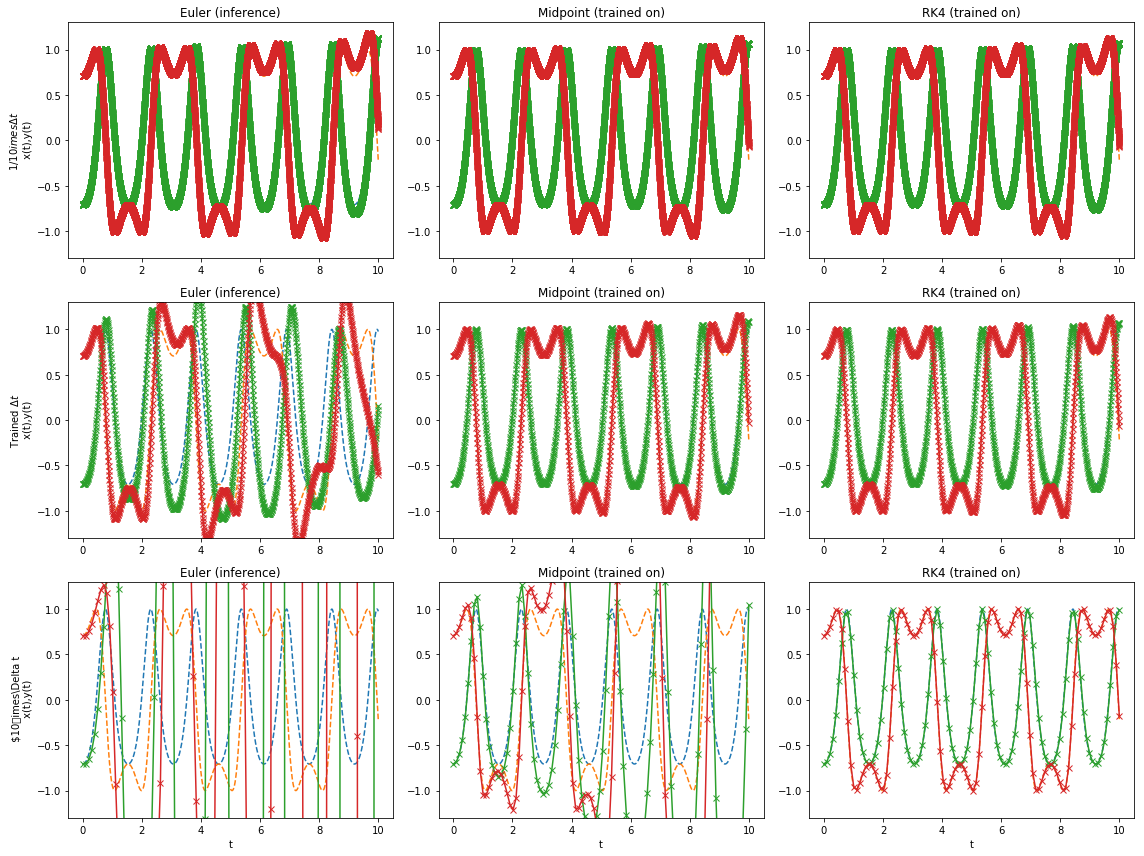

In [76]:
plot_3x3(xy_models['m+r'],xy_data,xy_ts,trained_on=(False,True,True))
plt.savefig('plots/pend_xy_infer_m+r.png')

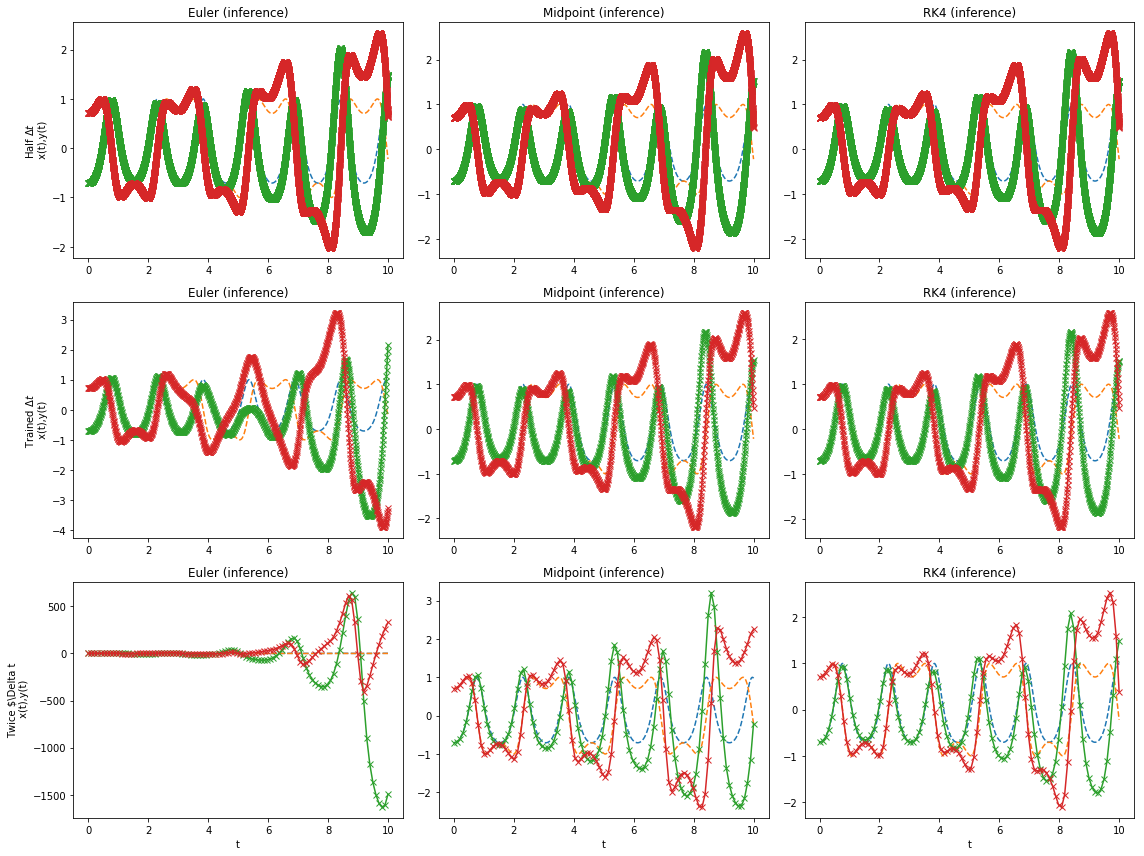

In [66]:
plot_3x3(xy_models['rk4'],xy_data,xy_ts,trained_on=(False,False,True))

ValueError: x and y must have same first dimension, but have shapes (17,) and (19,)

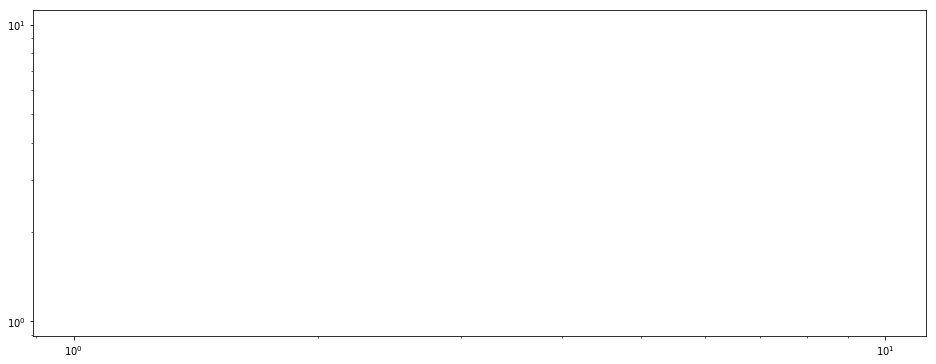

In [61]:
plot_error_rates(xy_runs)
plt.ylim(10**-6,10**2)
plt.savefig('plots/pend_xy_conv.png')